~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Quick start with Hugging Face

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fmedgemma%2Fmain%2Fnotebooks%2Fquick_start_with_hugging_face.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
</tr></tbody></table>

This notebook provides a basic demo of using MedGemma, a collection of Gemma 3 variants that are trained for performance on medical text and image comprehension. MedGemma is intended to accelerate building healthcare-based AI applications.

Learn more about the model at the [HAI-DEF developer site](https://developers.google.com/health-ai-developer-foundations/medgemma).

## Setup

To complete this tutorial, you'll need to have a runtime with [sufficient resources](https://ai.google.dev/gemma/docs/core#sizes) to run the MedGemma model.

You can try out MedGemma 4B for free in Google Colab using a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

**Note**: To run the demo with MedGemma 27B in Google Colab, you will need a runtime with an A100 GPU and use 4-bit quantization to reduce memory usage. The performance of quantized versions has not been evaluated.

### Get access to MedGemma

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-4b-it) and accept the usage conditions.

### Authenticate with Hugging Face

Generate a Hugging Face `read` access token by going to [settings](https://huggingface.co/settings/tokens).

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [ ]:
import os
import sys
from huggingface_hub import get_token

# Define sua chave da Hugging Face diretamente como uma variável de ambiente.
# Substitua "SUA_CHAVE_AQUI" pela sua chave real da Hugging Face.
# É uma boa prática não deixar a chave exposta no código, mas para rodar localmente,
# essa é a forma mais simples.
# Para maior segurança, você pode carregar isso de um arquivo .env, por exemplo.
os.environ["HF_TOKEN"] = "TOKEN_HUGGING_FACE"

# Opcional: Verifique se o token foi carregado (útil para depuração)
if get_token() is None:
    print("Aviso: A chave HF_TOKEN não foi carregada corretamente.")
else:
    print("Chave HF_TOKEN carregada com sucesso!")

# Se você quiser que os modelos e caches do Hugging Face sejam armazenados em um diretório específico,
# descomente a linha abaixo e ajuste o caminho. Por padrão, eles vão para ~/.cache/huggingface.
# os.environ["HF_HOME"] = "/caminho/para/seu/diretorio/hf"

Chave HF_TOKEN carregada com sucesso!


c:\Users\José Lúcio\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Install dependencies

In [2]:
! pip install --upgrade --quiet accelerate bitsandbytes transformers


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Set model variant and configuration

In [3]:
from transformers import BitsAndBytesConfig
import torch

model_variant = "4b-it"  # Mantemos a versão 4B
model_id = f"google/medgemma-{model_variant}"

# ESSA É A MUDANÇA CRÍTICA: Desativar a quantização
use_quantization = False

model_kwargs = dict(
    torch_dtype=torch.bfloat16, # Tenta usar bfloat16 para economia de memória
    device_map="auto",          # Deixa o Transformers decidir o melhor dispositivo (provavelmente sua CPU)
)

# O bloco if use_quantization não será executado, não adicionando a configuração de quantização
if use_quantization:
    model_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True)

print(f"Configuração do modelo MedGemma ({model_variant}):")
print(f"  ID do Modelo: {model_id}")
print(f"  Usar Quantização (4-bit): {use_quantization}")
print(f"  Argumentos do Modelo: {model_kwargs}")

# Lembre-se de carregar o modelo após esta célula:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id, **model_kwargs)

Configuração do modelo MedGemma (4b-it):
  ID do Modelo: google/medgemma-4b-it
  Usar Quantização (4-bit): False
  Argumentos do Modelo: {'torch_dtype': torch.bfloat16, 'device_map': 'auto'}


## Run inference on images and text

This section demonstrates running inference on image-based tasks using multimodal variants.

**Note:** Proceed to [Run inference on text only](#scrollTo=tcyXG4lTpY4X) if you have selected the 27B text-only variant.

In [4]:
if "text" in model_variant:
    raise ValueError(
        "You are using a text-only variant which does not support multimodal "
        "inputs. Please proceed to the 'Run inference on text only' section."
    )

**Specify image and text inputs**

Baixando imagem de: https://www.saskoer.ca/app/uploads/sites/290/2017/10/chest-case-4-2-1.jpg
Imagem salva como: chest-case-4-2-1.jpg


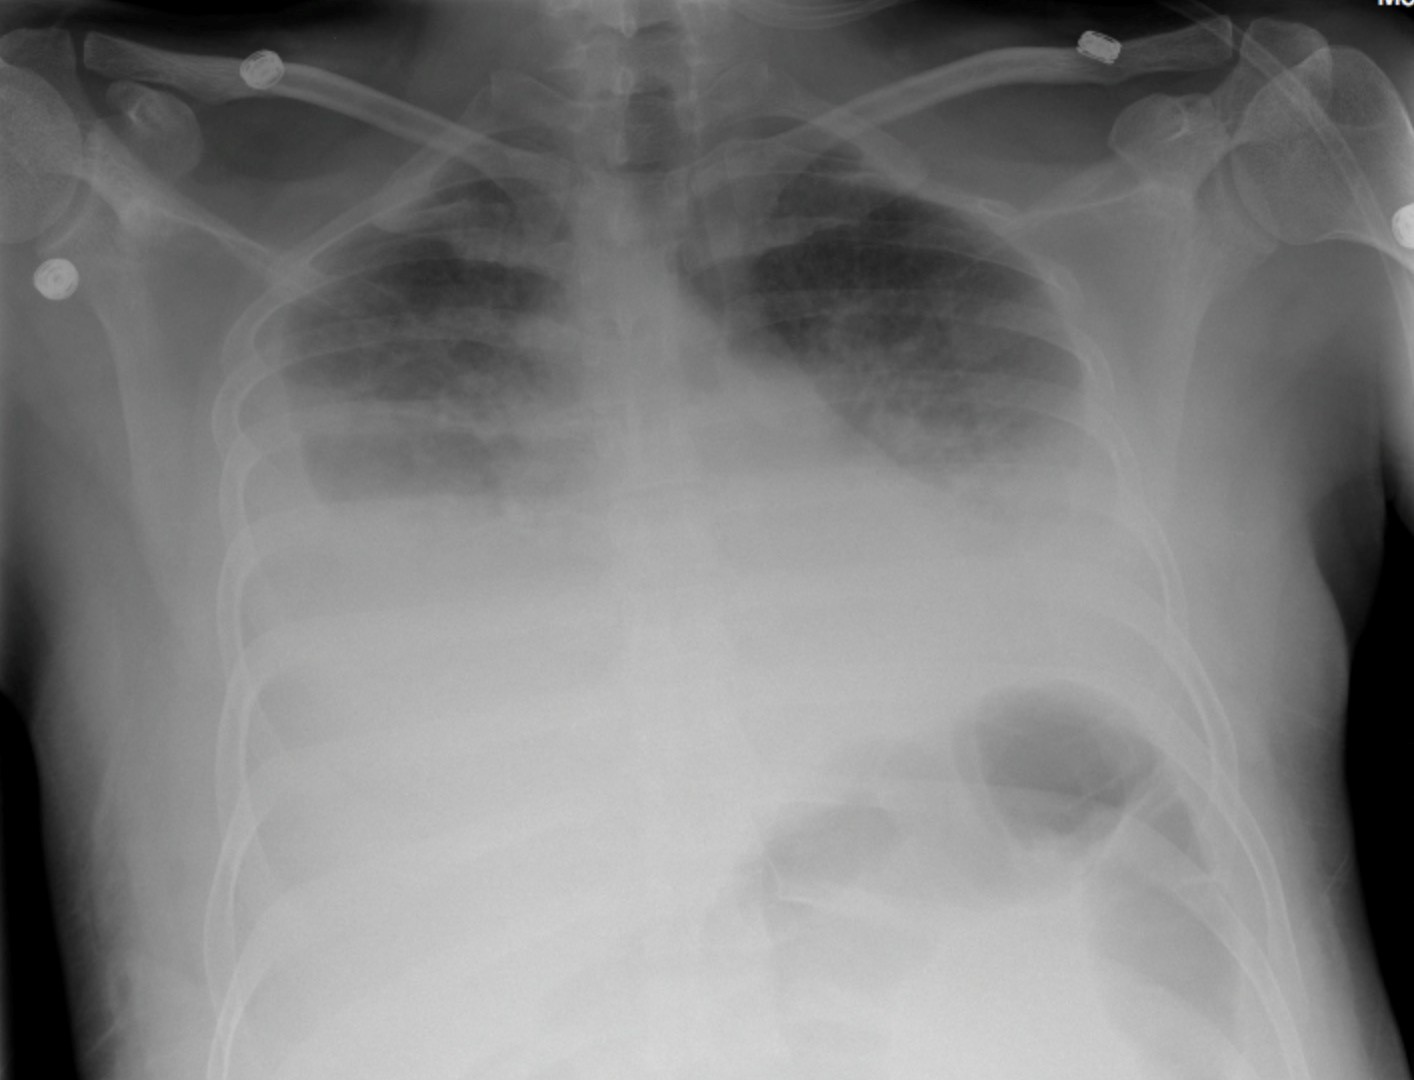

In [5]:
import os
from PIL import Image
from IPython.display import Image as IPImage, display, Markdown
import requests # Importar a biblioteca requests

prompt = "Describe this X-ray"
image_url = "https://www.saskoer.ca/app/uploads/sites/290/2017/10/chest-case-4-2-1.jpg"
image_filename = os.path.basename(image_url)

# Adicionar um cabeçalho User-Agent para simular um navegador
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36'
}

print(f"Baixando imagem de: {image_url}")
try:
    # Passar os cabeçalhos na requisição
    response = requests.get(image_url, headers=headers)
    response.raise_for_status() # Levanta um erro para códigos de status HTTP ruins (4xx ou 5xx)

    # Salvar a imagem no diretório local
    with open(image_filename, 'wb') as f:
        f.write(response.content)
    print(f"Imagem salva como: {image_filename}")

    # Abrir a imagem com PIL
    image = Image.open(image_filename)

    # Opcional: Exibir a imagem (se estiver em um ambiente como Jupyter/IPython)
    display(image)

except requests.exceptions.RequestException as e:
    print(f"Erro ao baixar a imagem: {e}")
    print("Por favor, verifique se a URL está correta ou se o site permite downloads programáticos.")
    print("Você pode tentar usar uma URL de imagem diferente se o problema persistir.")

# Agora você pode usar a variável 'image' com o seu modelo MedGemma

**Format conversation**

In [6]:
system_instruction = "You are an expert radiologist."

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": system_instruction}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {"type": "image", "image": image}
        ]
    }
]

The following standalone examples demonstate how to use the model both directly and with the [`pipeline`](https://huggingface.co/docs/transformers/en/main_classes/pipelines) API. The `pipeline` API provides a simple way to use the model for inference while abstracting away complex details,  while directly using the model gives you complete control over the inference process, including preprocessing and postprocessing. In practice, you should select the method that is best suited for your use case.

**Run model with the `pipeline` API**

In [7]:
from transformers import pipeline

pipe = pipeline(
    "image-text-to-text",
    model=model_id,
    model_kwargs=model_kwargs,
)

pipe.model.generation_config.do_sample = False

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]
c:\Users\José Lúcio\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\José Lúcio\.cache\huggingface\hub\models--google--medgemma-4b-it. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some para

In [ ]:
output = pipe(text=messages, max_new_tokens=300)
response = output[0]["generated_text"][-1]["content"]

display(Markdown(f"\n\n---\n\n**[ User ]**\n\n{prompt}"))
display(IPImage(filename=image_filename,height=300))
display(Markdown(f"\n\n---\n\n**[ MedGemma ]**\n\n{response}\n\n---\n\n"))

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


**Run the model directly**

In [7]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    **model_kwargs,
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

: 

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.




---

**[ User ]**

Describe this X-ray

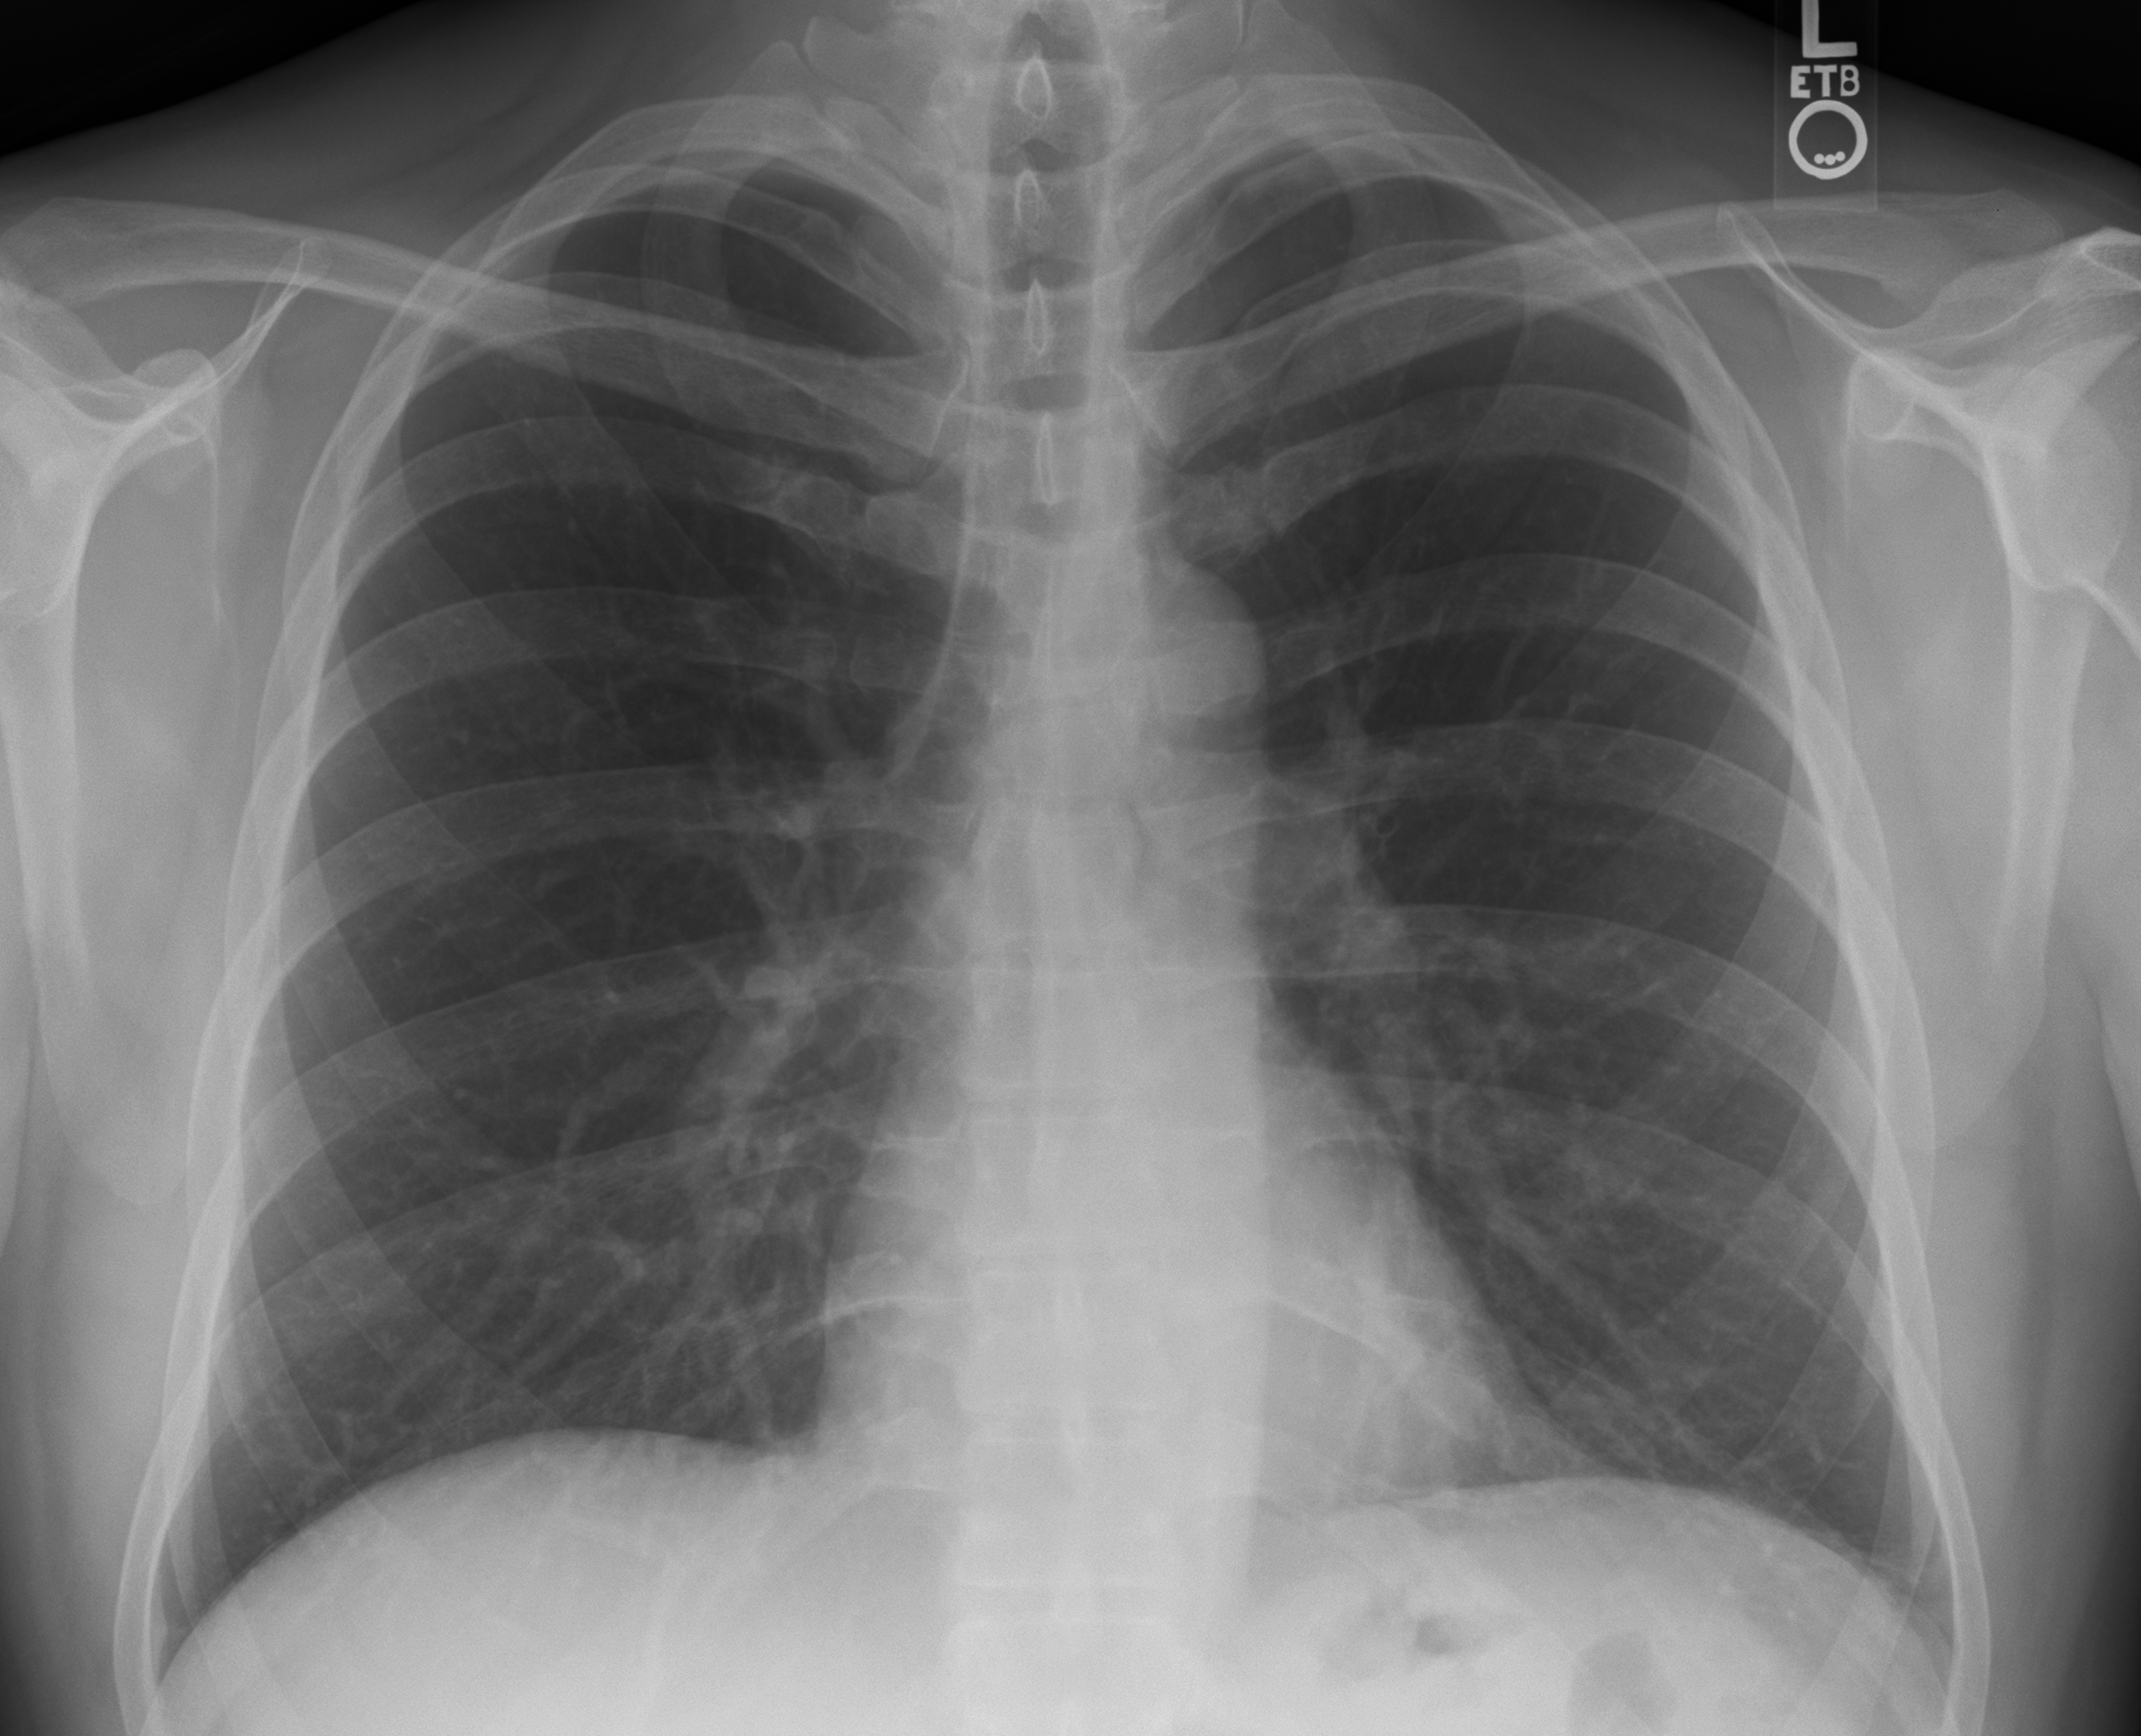



---

**[ MedGemma ]**

Okay, I've reviewed the provided chest X-ray. Here's a description of what I see:

**Overall Impression:**

The X-ray shows a normal adult chest. The lungs appear clear, with no obvious signs of consolidation, effusion, or pneumothorax. The heart size and mediastinal contours are within normal limits.

**Specific Findings:**

*   **Lung Fields:** The lung fields are clear, with no evidence of consolidation, effusion, or pneumothorax.
*   **Heart Size:** The heart size appears normal.
*   **Mediastinum:** The mediastinum is unremarkable.
*   **Ribs:** The ribs appear intact.
*   **Clavicles:** The clavicles appear intact.
*   **Soft Tissues:** The soft tissues of the chest wall are unremarkable.

**In summary, the X-ray is normal.**

**Important Considerations:**

*   This is a single view. A full chest X-ray would include both PA (posterior-anterior) and lateral views for a more comprehensive assessment.
*   The patient's clinical history is crucial for interpreting the X-ray.
*   This interpretation is based solely on the provided image.

**Disclaimer:** This is a preliminary interpretation based on a single image. A definitive diagnosis requires a complete clinical evaluation and potentially additional imaging studies.


---



In [ ]:
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device, dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=300, do_sample=False)
    generation = generation[0][input_len:]

decoded = processor.decode(generation, skip_special_tokens=True)

display(Markdown(f"\n\n---\n\n**[ User ]**\n\n{prompt}"))
display(IPImage(filename=image_filename,height=300))
display(Markdown(f"\n\n---\n\n**[ MedGemma ]**\n\n{decoded}\n\n---\n\n"))

## Run inference on text only

This section demonstrates running inference on text-based tasks.

**Specify text prompt and format conversation**

In [ ]:
from IPython.display import Markdown

prompt = "I have this feeling of head spinning when i get up from the bed or when i am going to lie down on the right side. This subsides immediatlef after some time . What is the possible diagnosis?"  # @param {type: "string"}

system_instruction = "You are a helpful medical assistant."

messages = [
    {
        "role": "system",
        "content": system_instruction
    },
    {
        "role": "user",
        "content": prompt
    }
]

The following standalone examples demonstate how to use the model both directly and with the [`pipeline`](https://huggingface.co/docs/transformers/en/main_classes/pipelines) API. The `pipeline` API provides a simple way to use the model for inference while abstracting away complex details,  while directly using the model gives you complete control over the inference process, including preprocessing and postprocessing. In practice, you should select the method that is best suited for your use case.

**Run model with the `pipeline` API**

In [ ]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs=model_kwargs,
)

pipe.model.generation_config.do_sample = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
output = pipe(messages, max_new_tokens=500)
response = output[0]["generated_text"][-1]["content"]

display(Markdown(f"\n\n---\n\n**[ User ]**\n\n{prompt}\n\n---\n\n"))
display(Markdown(f"**[ MedGemma ]**\n\n{response}\n\n---\n\n"))



---

**[ User ]**

I have this feeling of head spinning when i get up from the bed or when i am going to lie down on the right side. This subsides immediatlef after some time . What is the possible diagnosis?

---



**[ MedGemma ]**

Okay, I understand you're experiencing a feeling of head spinning when getting up from bed or when lying down on the right side, which subsides quickly. This is important information to help me narrow down the possibilities.

Here's a breakdown of potential causes, ranging from more common to less common, and why they might present this way:

**Possible Causes:**

*   **Orthostatic Hypotension (Low Blood Pressure Upon Standing):** This is a very common cause. When you stand up, gravity pulls blood down to your legs. Your body tries to compensate by releasing hormones that constrict blood vessels and increase heart rate. If this compensation isn't fast enough, blood flow to the brain can decrease, leading to dizziness, lightheadedness, and sometimes a feeling of spinning (vertigo).
    *   **Why it's likely:** The timing (when getting up or lying down) and the quick resolution suggest this is a likely culprit.
    *   **Contributing Factors:** Dehydration, certain medications (especially blood pressure medications, diuretics, and some antidepressants), anemia, and underlying medical conditions can worsen orthostatic hypotension.

*   **Benign Paroxysmal Positional Vertigo (BPPV):** This is a relatively common cause of vertigo, characterized by brief episodes of intense dizziness or spinning that are triggered by specific head movements, particularly changes in head position (like getting up or lying down). The spinning sensation is caused by calcium crystals dislodging in the inner ear.
    *   **Why it's likely:** The fact that the spinning occurs with positional changes (lying down on the right side, getting up from bed) is a strong indicator.
    *   **Important Note:** BPPV is not usually associated with any other symptoms.

*   **Vestibular Neuritis:** This is an inflammation of the vestibular nerve, which is responsible for balance. It can cause sudden, severe vertigo, often accompanied by nausea and vomiting. The vertigo usually lasts for several days and can be triggered by head movements.
    *   **Less Likely:** Vestibular neuritis is less likely to be triggered *only* by positional changes. It's more often associated with a more intense, persistent, and continuous spinning sensation.

*   **Meniere's Disease:** This is a chronic inner ear disorder that can cause vertigo, tinnitus (ringing in the ears), hearing loss, and a feeling of fullness in

---



**Run the model directly**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    **model_kwargs,
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=500, do_sample=False)
    generation = generation[0][input_len:]

decoded = tokenizer.decode(generation, skip_special_tokens=True)

display(Markdown(f"\n\n---\n\n**[ User ]**\n\n{prompt}\n\n---\n\n"))
display(Markdown(f"**[ MedGemma ]**\n\n{decoded}\n\n---\n\n"))

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.




---

**[ User ]**

How do you differentiate bacterial from viral pneumonia?

---



**[ MedGemma ]**

Okay, I can help you understand the differences between bacterial and viral pneumonia. While I can't provide a definitive diagnosis (that requires a doctor's evaluation), I can outline the key distinctions based on common symptoms, risk factors, and diagnostic methods.

**Key Differences Between Bacterial and Viral Pneumonia:**

| Feature          | Bacterial Pneumonia                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

---



# Next steps

Explore the other [notebooks](https://github.com/google-health/medgemma/blob/main/notebooks) to learn what else you can do with the model.